## Important notes

- The Fourier series fit can be done via two ways. Fitting $sine$ or $cosine$ functions:

 $$ \sum_i A_i sin( 2\pi f_i t + \phi_i ) + constant $$,

 $$ \sum_i A_i cos( 2\pi f_i t + \phi_i ) + constant $$

 where $A_i$ is the semi-amplitude, $f_i$ is the frequency and $\phi_i$ is the phase of the given component. The _constant_ is the zero point of the light curve.

 This is __optional in the code__. Use the keyword `kind='sin'` or `kind='cos'` to select one. The default is _sine_.

- After the fitting of ___at least___ 3 frequencies the Fourier parameters are calculated as

 $$ R_{21} = \frac{A_2}{A_1} $$ ,
 $$ R_{31} = \frac{A_3}{A_1} $$ ,
 $$ \phi_{21} = \phi_2 - 2 \phi_1 $$ ,
 $$ \phi_{31} = \phi_3 - 3 \phi_1 $$

 which values __depend on__ the ___chosen function (sine or cosine)___, the ___physical units (flux or mag)___ and the passband. The more the harmonics, the more accurate the results. Set `nfreq` to a very large number to get all harmonics. The number of harmonincs will be limited by the signal-to-noise ratios.

- __The code first finds the frequency with the highest peak in the spectrum__ and after that does a consequtive pre-whitening with the integer multiples of that frequency. Thus, if we want to calculate the Fourier parameters of e.g. the second overtone, we have to put constraints on the frequency range to be checked i.e. `minimum_frequency` and `maximum_frequency` must be defined. Otherwise the highest peak in the spectrum will be considered.

- __Errors are estimated analytically by default__ using the formulae of Breger, 1999, A&A, 349, 225.

 $$ \sigma(f) = \sqrt{\frac{6}{N}} \frac{1}{\pi T} \frac{\sigma(m)}{a} $$ ,
 $$ \sigma(a) = \sqrt{\frac{2}{N}} \sigma(m) $$ ,
 $$ \sigma(\phi) = \sqrt{\frac{1}{2\pi}} \sqrt{\frac{2}{N}} \frac{\sigma(m)}{a} $$

- __Errors__ can also be estimated in two other, more reliable ways.

 - Set `error_estimation` to `'bootstrap'` to enable the bootstrap method.
 
 - Or set `error_estimation` to `'montecarlo'` to enable the monte carlo method.
 
 Both methods generate new light curves `ntry` times and fit each dataset induvidually. The results are collected and the parameter uncertenties are estimated from the distributions.
 
 To generate new data sets the _bootstrap_ method subsamples the light curve. The number of sampled points are controlled by the `sample_size` (= ratio between 0-1) parameter.
 
 The _monte carlo_ method generates light curves with the same number of points as the original number of points. Each brightness measurement is resampled from a Gaussian with mean equals to the original brightness and std equals to the noise. If light curves noise is not known, then it is estimated from the residual light curve.
 
 To speed up the sampling process, the code can be run parallel via setting `parallel` to `True`. By deafult, all the CPU cores are used, but this can be limited by setting `ncores`.
 
 The resulted distributions and their correlations can be visualized by setting `plotting` to `True`. However, to decouple the frequencies from the phases the time points are constrained by
 
 $$ \sum_i t_i = 1 $$

 Thus, the absolute values of the plotted phases will differ from the returned ones. They are only used to estimate errors.

- If due to sparse sampling the __Nyquist limit is low (e.g. in case of ground-based data)__, set `maximum_frequency` to overwrite the default Nyquist limit.

# The code

In [13]:
from seismolab.fourier import MultiHarmonicFitter, MultiFrequencyFitter

import numpy as np
import matplotlib.pyplot as plt

## Load example lc

In [4]:
lc = np.loadtxt("https://ogledb.astrouw.edu.pl/~ogle/OCVS/data/I/01/OGLE-LMC-CEP-0001.dat").T

# Store results in separate arrays for clarity
t = lc[0]
y = lc[1]
yerr = lc[2]

In [5]:
# Initialize fitter by passing your light curve
fitter = MultiHarmonicFitter(t,y)

swf,swp = fitter.get_spectral_window(maximum_frequency=10)

## Prewhitening with given number of frequencies 

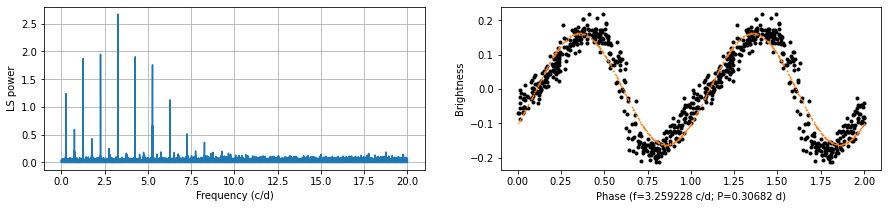

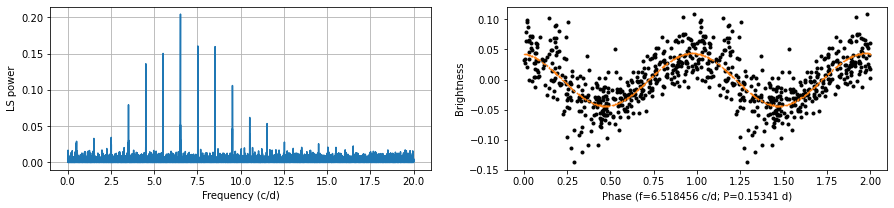

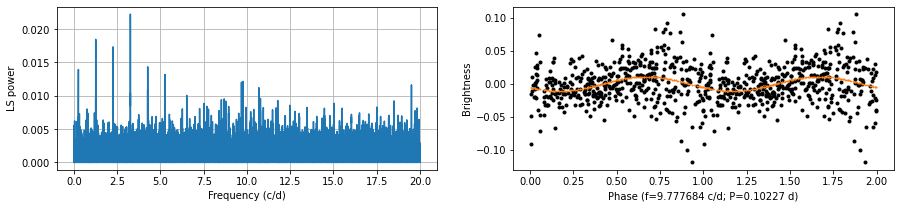

In [7]:
# Initialize fitter by passing your light curve
fitter = MultiHarmonicFitter(t,y)

# The same can be done with measurement errors
#fitter = MultiHarmonicFitter(t,y,yerr)

# Do the Fourier calculation
maxharmonics = 3  # Set to e.g. 9999 to fit all harmonics

pfit,perr = fitter.fit_harmonics(maxharmonics = maxharmonics,
                                 plotting = True,
                                 minimum_frequency=None,
                                 maximum_frequency=20,        # Overwrites nyquist_factor!
                                 nyquist_factor=1,
                                 samples_per_peak=100,        # Oversampling factor in Lomb-Scargle spectrum calculation
                                 error_estimation='analytic', # Method of the error estimation
                                 ntry=1000,                   # Number of samplings if method is NOT analytic
                                 sample_size=0.999,           # Subsample size if method is bootstrap
                                 parallel=True,ncores=-1,
                                 kind='sin' )

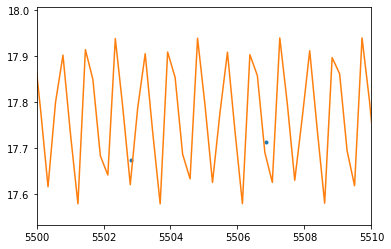

In [8]:
tmodel = np.linspace(t.min(),t.max(),10000)
ymodel = fitter.lc_model(tmodel,*pfit)

plt.plot(t,y,'.')
plt.plot(tmodel,ymodel)
plt.xlim(5500,5510)
plt.show()

Get residual light curve if needed

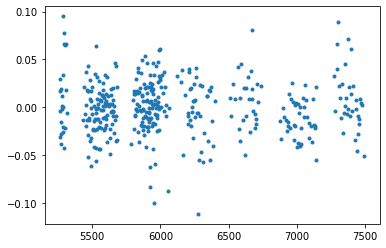

In [9]:
try:
    t, resy, resyerr = fitter.get_residual()
except ValueError:
    t, resy = fitter.get_residual()

plt.plot(t,resy,'.')
plt.show()

## Print results

In [10]:
print('freq = ', pfit[0], perr[0])

ncomponents = int((len(pfit)-1)/2)
for i in range(1, ncomponents + 1 ):
    print('A%d   = ' % i,   pfit[i],             perr[i])
    print('Phi%d = ' % i,   pfit[i+ncomponents], perr[i+ncomponents])
    
print('Zero point =', pfit[-1], perr[-1])

freq =  3.2592362904428214 2.98988095979671e-06
A1   =  0.16336913070622472 0.0019783195716082465
Phi1 =  5.313545279226284 0.001927287838747718
A2   =  0.04500348929038714 0.0019783195716082465
Phi2 =  1.1331431672839236 0.0069963317023097596
A3   =  0.010661165765036451 0.0019783195716082465
Phi3 =  2.7252836438597896 0.029533293616865245
Zero point = 17.767696179330027 0.05039919157419217


## Calculate Fourier parameters

In [11]:
freq,period,Rn1,Phin1 = fitter.get_fourier_parameters()

print('freq = ',  freq.n,   freq.s)
print('period = ',period.n, period.s)
for i,(Rn,Phin) in enumerate(zip(Rn1,Phin1)):
    print('R%d1 = ' % (i+2),     Rn.n,    Rn.s)
    print('Phi%d1 = ' % (i+2),   Phin.n,  Phin.s)

freq =  3.2592362904428214 2.98988095979671e-06
period =  0.3068203440580043 2.8146357705555137e-07
R21 =  0.2754711927268179 0.012560567164327118
Phi21 =  3.072423223190528 0.007987891520437917
R31 =  0.0652581409899749 0.012135264160974022
Phi31 =  5.6342037277196955 0.030093942539661318


In [ ]:
# Initialize fitter by passing your light curve
fitter = MultiHarmonicFitter(t,y)

# The same can be done with measurement errors
#fitter = MultiHarmonicFitter(t,y,yerr)

# Do the Fourier calculation
maxharmonics = 10  # Set to e.g. 9999 to fit all harmonics

pfit,perr = fitter.fit_harmonics(maxharmonics = maxharmonics,
                                 plotting = True,
                                 scale='mag',
                                 minimum_frequency=None,
                                 maximum_frequency=20,        # Overwrites nyquist_factor!
                                 nyquist_factor=1,
                                 samples_per_peak=10,        # Oversampling factor in Lomb-Scargle spectrum calculation
                                 error_estimation='montecarlo', # Method of the error estimation
                                 ntry=1000,                   # Number of samplings if method is NOT analytic
                                 sample_size=0.7,           # Subsample size if method is bootstrap
                                 parallel=True,ncores=-1,
                                 kind='sin')

In [ ]:
tmodel = np.linspace(t.min(),t.max(),100000)
ymodel = fitter.lc_model(tmodel,*pfit)

plt.plot(t,y,'.')
plt.plot(tmodel,ymodel)
plt.xlim(5500,5510)
plt.show()

In [ ]:
print('freq = ', pfit[0], perr[0])

ncomponents = int((len(pfit)-1)/2)
for i in range(1, ncomponents + 1 ):
    print('A%d   = ' % i,   pfit[i],             perr[i])
    print('Phi%d = ' % i,   pfit[i+ncomponents], perr[i+ncomponents])
    
print('Zero point =', pfit[-1], perr[-1])

In [ ]:
# Initialize fitter by passing your light curve
fitter = MultiFrequencyFitter(t,y)

# The same can be done with measurement errors
fitter = MultiFrequencyFitter(t,y,yerr)

# Do the Fourier calculation
maxfreqs = 3  # Set to e.g. 9999 to get all frequencies

pfit,perr = fitter.fit_freqs(maxfreqs = maxfreqs,
                             sigma=4,
                             plotting = False,scale='mag',
                             minimum_frequency=None,
                             maximum_frequency=20,        # Overwrites nyquist_factor!
                             nyquist_factor=1,
                             samples_per_peak=10,        # Oversampling factor in Lomb-Scargle spectrum calculation
                             error_estimation='analytic', # Method of the error estimation
                             ntry=1000,                   # Number of samplings if method is NOT analytic
                             sample_size=0.7,           # Subsample size if method is bootstrap
                             parallel=True,ncores=-1,
                             kind='sin')

In [ ]:
try:
    tres,yres = fitter.get_residual()
except:
     tres,yres,yerrrres = fitter.get_residual()

In [ ]:
tmodel = np.linspace(t.min(),t.max(),100000)
ymodel = fitter.lc_model(tmodel,*pfit)

plt.plot(t,y,'.')
plt.plot(tmodel,ymodel)
plt.xlim(5500,5510)
plt.show()

In [ ]:
ncomponents = int((len(pfit)-1)//3)
for i in range(ncomponents):
    print('f%d   = ' % (i+1),    pfit[i],             perr[i])
    print('A%d   = ' % (i+1),   pfit[i+ncomponents], perr[i+ncomponents])
    print('Phi%d = ' % (i+1),   pfit[i+2*ncomponents], perr[i+2*ncomponents])
    
print('Zero point =', pfit[-1], perr[-1])

In [ ]:
swf,swp = fitter.get_spectral_window(maximum_frequency=10)

plt.plot(swf,swp)
plt.show()